(lake_model)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# A Lake Model of Employment and Unemployment

```{index} single: Lake Model
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

This lecture describes what has come to be called a *lake model*.

The lake model is a basic tool for modeling unemployment.

It allows us to analyze

* flows between unemployment and employment.
* how these flows influence steady state employment and unemployment rates.

It is a good model for interpreting monthly labor department reports on gross and net jobs created and jobs destroyed.

The "lakes" in the model are the pools of employed and unemployed.

The "flows" between the lakes are caused by

* firing and hiring
* entry and exit from the labor force

For the first part of this lecture, the parameters governing transitions into
and out of unemployment and employment are exogenous.

Later, we'll determine some of these transition rates endogenously using the {doc}`McCall search model <mccall_model>`.

We'll also use some nifty concepts like ergodicity, which provides a fundamental link between *cross-sectional* and *long run time series* distributions.

These concepts will help us build an equilibrium model of ex-ante homogeneous workers whose different luck generates variations in their ex post experiences.

Let's start with some imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from quantecon import MarkovChain
from scipy.stats import norm
from scipy.optimize import brentq
from quantecon.distributions import BetaBinomial
from numba import jit

### Prerequisites

Before working through what follows, we recommend you read the
{doc}`lecture on finite Markov chains <finite_markov>`.

You will also need some basic {doc}`linear algebra <linear_algebra>` and probability.

## The Model

The economy is inhabited by a very large number of ex-ante identical workers.

The workers live forever, spending their lives moving between unemployment and employment.

Their rates of  transition between employment and unemployment are  governed by the following parameters:

* $\lambda$, the job finding rate for currently unemployed workers
* $\alpha$, the dismissal rate for currently employed workers
* $b$, the entry rate into the labor force
* $d$, the exit rate from the labor force

The growth rate of the labor force evidently equals $g=b-d$.

### Aggregate Variables

We want to derive the dynamics of the following aggregates

* $E_t$, the total number of employed workers at date $t$
* $U_t$, the total number of unemployed workers at $t$
* $N_t$, the number of workers in the labor force at $t$

We also want to know the values of the following objects

* The employment rate $e_t := E_t/N_t$.
* The unemployment rate $u_t := U_t/N_t$.

(Here and below, capital letters represent aggregates and lowercase letters represent rates)

### Laws of Motion for Stock Variables

We begin by constructing laws of motion for the aggregate variables $E_t,U_t, N_t$.

Of the mass of workers $E_t$ who are employed at date $t$,

* $(1-d)E_t$ will remain in the labor force
* of these, $(1-\alpha)(1-d)E_t$ will remain employed

Of the mass of workers $U_t$ workers who are currently unemployed,

* $(1-d)U_t$ will remain in the labor force
* of these, $(1-d) \lambda U_t$ will become employed

Therefore,  the number of workers who will be employed at date $t+1$ will be

$$
E_{t+1} = (1-d)(1-\alpha)E_t + (1-d)\lambda U_t
$$

A similar analysis implies

$$
U_{t+1} = (1-d)\alpha E_t + (1-d)(1-\lambda)U_t + b (E_t+U_t)
$$

The value $b(E_t+U_t)$ is the mass of new workers entering the labor force unemployed.

The total stock of workers $N_t=E_t+U_t$ evolves as

$$
N_{t+1} = (1+b-d)N_t = (1+g)N_t
$$

Letting $X_t := \left(\begin{matrix}U_t\\E_t\end{matrix}\right)$, the law of motion for $X$  is

$$
X_{t+1} = A X_t
\quad \text{where} \quad
A :=
\begin{pmatrix}
    (1-d)(1-\lambda) + b & (1-d)\alpha + b  \\
    (1-d)\lambda & (1-d)(1-\alpha)
\end{pmatrix}
$$

This law tells us how total employment and unemployment evolve over time.

### Laws of Motion for Rates

Now let's derive the law of motion for rates.

To get these we can divide both sides of $X_{t+1} = A X_t$ by  $N_{t+1}$ to get

$$
\begin{pmatrix}
    U_{t+1}/N_{t+1} \\
    E_{t+1}/N_{t+1}
\end{pmatrix} =
\frac1{1+g} A
\begin{pmatrix}
    U_{t}/N_{t}
    \\
    E_{t}/N_{t}
\end{pmatrix}
$$

Letting

$$
x_t :=
\left(\begin{matrix}
    u_t\\ e_t
\end{matrix}\right) =
\left(\begin{matrix}
    U_t/N_t\\ E_t/N_t
\end{matrix}\right)
$$

we can also write this as

$$
x_{t+1} = \hat A x_t
\quad \text{where} \quad
\hat A := \frac{1}{1 + g} A
$$

You can check that $e_t + u_t = 1$ implies that $e_{t+1}+u_{t+1} = 1$.

This follows from the fact that the columns of $\hat A$ sum to 1.

## Implementation

Let's code up these equations.

To do this we're going to use a class that we'll call `LakeModel`.

This class will

1. store the primitives $\alpha, \lambda, b, d$
1. compute and store the implied objects $g, A, \hat A$
1. provide methods to simulate dynamics of the stocks and rates
1. provide a method to compute the steady state of the rate

Please be careful because the implied objects $g, A, \hat A$ will not change
if you only change the primitives.

For example, if you would like to update a primitive like $\alpha = 0.03$,
you need to create an instance and update it by `lm = LakeModel(α=0.03)`.

In the exercises, we show how to avoid this issue by using getter and setter methods.

In [3]:
class LakeModel:
    """
    Solves the lake model and computes dynamics of unemployment stocks and
    rates.

    Parameters:
    ------------
    λ : scalar
        The job finding rate for currently unemployed workers
    α : scalar
        The dismissal rate for currently employed workers
    b : scalar
        Entry rate into the labor force
    d : scalar
        Exit rate from the labor force

    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self.λ, self.α, self.b, self.d = λ, α, b, d

        λ, α, b, d = self.λ, self.α, self.b, self.d
        self.g = b - d
        self.A = np.array([[(1-d) * (1-λ) + b,      (1 - d) * α + b],
                           [        (1-d) * λ,      (1 - d) * (1 - α)]])

        self.A_hat = self.A / (1 + self.g)


    def rate_steady_state(self, tol=1e-6):
        """
        Finds the steady state of the system :math:`x_{t+1} = \hat A x_{t}`

        Returns
        --------
        xbar : steady state vector of employment and unemployment rates
        """
        x = np.full(2, 0.5)
        error = tol + 1
        while error > tol:
            new_x = self.A_hat @ x
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x

    def simulate_stock_path(self, X0, T):
        """
        Simulates the sequence of Employment and Unemployment stocks

        Parameters
        ------------
        X0 : array
            Contains initial values (E0, U0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        X : iterator
            Contains sequence of employment and unemployment stocks
        """

        X = np.atleast_1d(X0)  # Recast as array just in case
        for t in range(T):
            yield X
            X = self.A @ X

    def simulate_rate_path(self, x0, T):
        """
        Simulates the sequence of employment and unemployment rates

        Parameters
        ------------
        x0 : array
            Contains initial values (e0,u0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        x : iterator
            Contains sequence of employment and unemployment rates

        """
        x = np.atleast_1d(x0)  # Recast as array just in case
        for t in range(T):
            yield x
            x = self.A_hat @ x

As explained, if we create an instance and update it by `lm = LakeModel(α=0.03)`,
derived objects like $A$ will also change.

In [4]:
lm = LakeModel()
lm.α

0.013

In [5]:
lm.A

array([[0.72350626, 0.02529314],
       [0.28067374, 0.97888686]])

In [6]:
lm = LakeModel(α = 0.03)
lm.A

array([[0.72350626, 0.0421534 ],
       [0.28067374, 0.9620266 ]])

### Aggregate Dynamics

Let's run a simulation under the default parameters (see above) starting from $X_0 = (12, 138)$

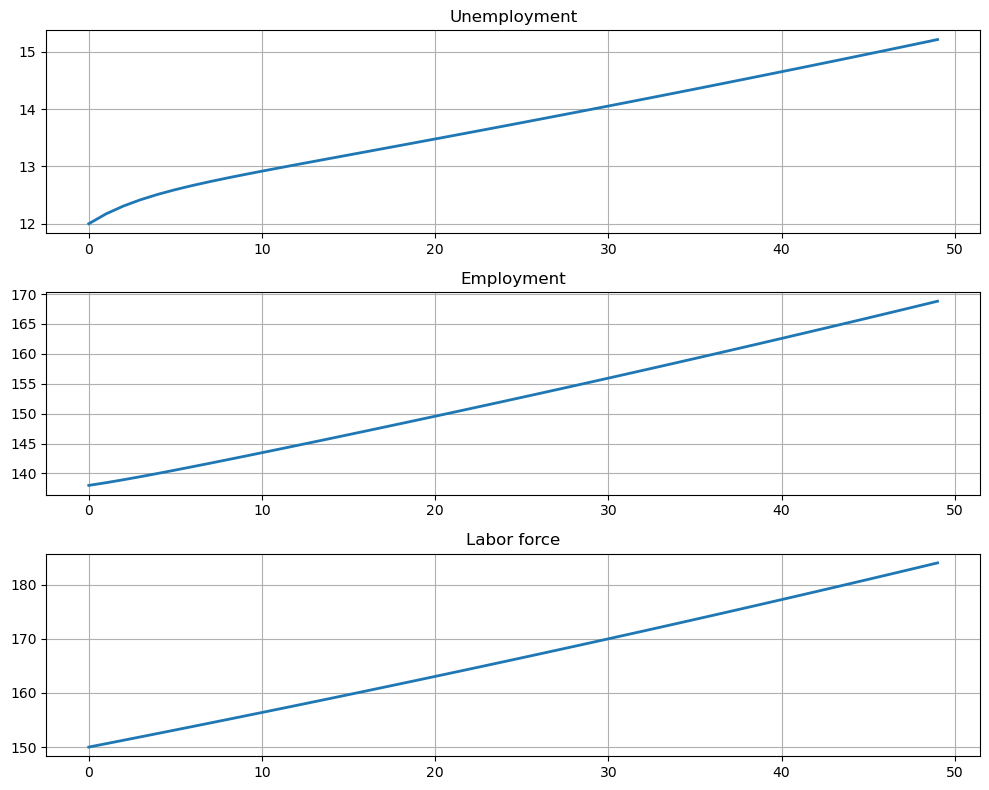

In [7]:
lm = LakeModel()
N_0 = 150      # Population
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

U_0 = u_0 * N_0
E_0 = e_0 * N_0

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
X_0 = (U_0, E_0)
X_path = np.vstack(tuple(lm.simulate_stock_path(X_0, T)))

axes[0].plot(X_path[:, 0], lw=2)
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1], lw=2)
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1), lw=2)
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

The aggregates $E_t$ and $U_t$ don't converge because  their sum $E_t + U_t$ grows at rate $g$.

On the other hand, the vector of employment and unemployment rates $x_t$ can be in a steady state $\bar x$ if
there exists an $\bar x$  such that

* $\bar x = \hat A \bar x$
* the components satisfy $\bar e + \bar u = 1$

This equation tells us that a steady state level $\bar x$ is an  eigenvector of $\hat A$ associated with a unit eigenvalue.

We also have $x_t \to \bar x$ as $t \to \infty$ provided that the remaining eigenvalue of $\hat A$ has modulus less than 1.

This is the case for our default parameters:

In [8]:
lm = LakeModel()
e, f = np.linalg.eigvals(lm.A_hat)
abs(e), abs(f)

(0.6953067378358462, 1.0)

Let's look at the convergence of the unemployment and employment rate to steady state levels (dashed red line)

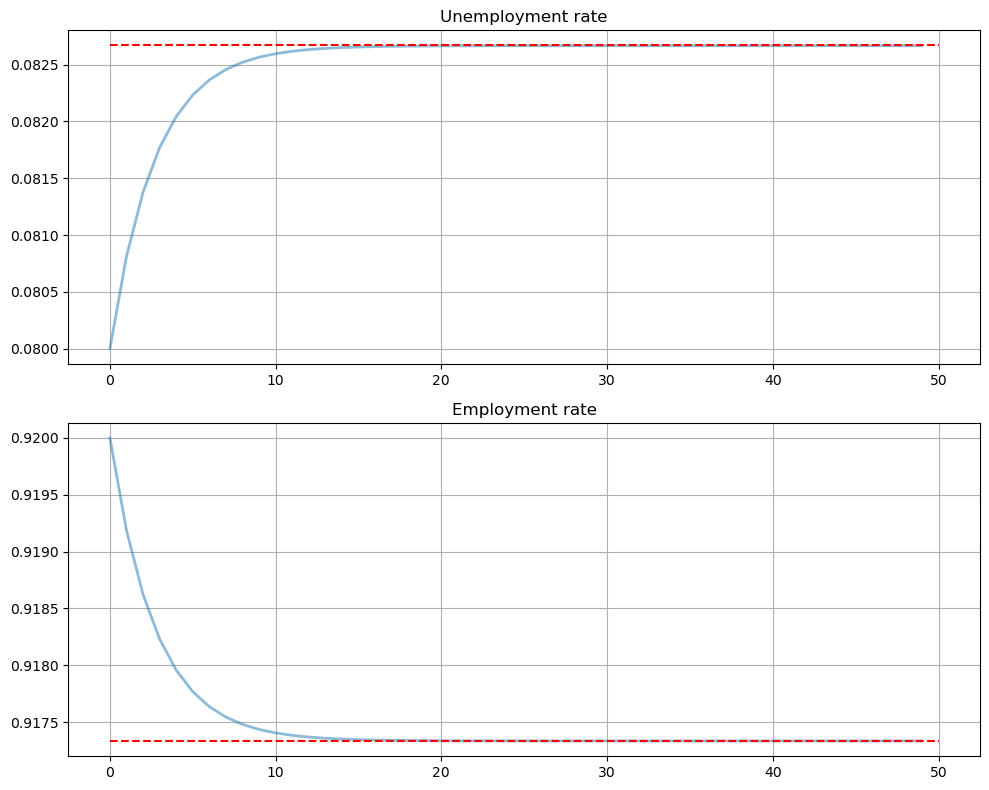

In [9]:
lm = LakeModel()
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
x_0 = (u_0, e_0)
x_path = np.vstack(tuple(lm.simulate_rate_path(x_0, T)))

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i], lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

## Dynamics of an Individual Worker

An individual worker's employment dynamics are governed by a {doc}`finite state Markov process <finite_markov>`.

The worker can be in one of two states:

* $s_t=0$ means unemployed
* $s_t=1$ means employed

Let's start off under the assumption that $b = d = 0$.

The associated transition matrix is then

$$
P = \left(
        \begin{matrix}
            1 - \lambda & \lambda \\
            \alpha & 1 - \alpha
        \end{matrix}
    \right)
$$

Let $\psi_t$ denote the {ref}`marginal distribution <mc_md>` over employment/unemployment states for the worker at time $t$.

As usual, we regard it as a row vector.

We know {ref}`from an earlier discussion <mc_md>` that $\psi_t$ follows the law of motion

$$
\psi_{t+1} = \psi_t P
$$

We also know from the {doc}`lecture on finite Markov chains <finite_markov>`
that if $\alpha \in (0, 1)$ and $\lambda \in (0, 1)$, then
$P$ has a unique stationary distribution, denoted here by $\psi^*$.

The unique stationary distribution satisfies

$$
\psi^*[0] = \frac{\alpha}{\alpha + \lambda}
$$

Not surprisingly, probability mass on the unemployment state increases with
the dismissal rate and falls with the job finding rate.

### Ergodicity

Let's look at a typical lifetime of employment-unemployment spells.

We want to compute the average amounts of time an infinitely lived worker would spend employed and unemployed.

Let

$$
\bar s_{u,T} := \frac1{T} \sum_{t=1}^T \mathbb 1\{s_t = 0\}
$$

and

$$
\bar s_{e,T} := \frac1{T} \sum_{t=1}^T \mathbb 1\{s_t = 1\}
$$

(As usual, $\mathbb 1\{Q\} = 1$ if statement $Q$ is true and 0 otherwise)

These are the fraction of time a worker spends unemployed and employed, respectively, up until period $T$.

If $\alpha \in (0, 1)$ and $\lambda \in (0, 1)$, then $P$ is {ref}`ergodic <ergodicity>`, and hence we have

$$
\lim_{T \to \infty} \bar s_{u, T} = \psi^*[0]
\quad \text{and} \quad
\lim_{T \to \infty} \bar s_{e, T} = \psi^*[1]
$$

with probability one.

Inspection tells us that $P$ is exactly the transpose of $\hat A$ under the assumption $b=d=0$.

Thus, the percentages of time that an  infinitely lived worker  spends employed and unemployed equal the fractions of workers employed and unemployed in the steady state distribution.

### Convergence Rate

How long does it take for time series sample averages to converge to cross-sectional averages?

We can use [QuantEcon.py's](http://quantecon.org/quantecon-py)
MarkovChain class to investigate this.

Let's plot the path of the sample averages over 5,000 periods

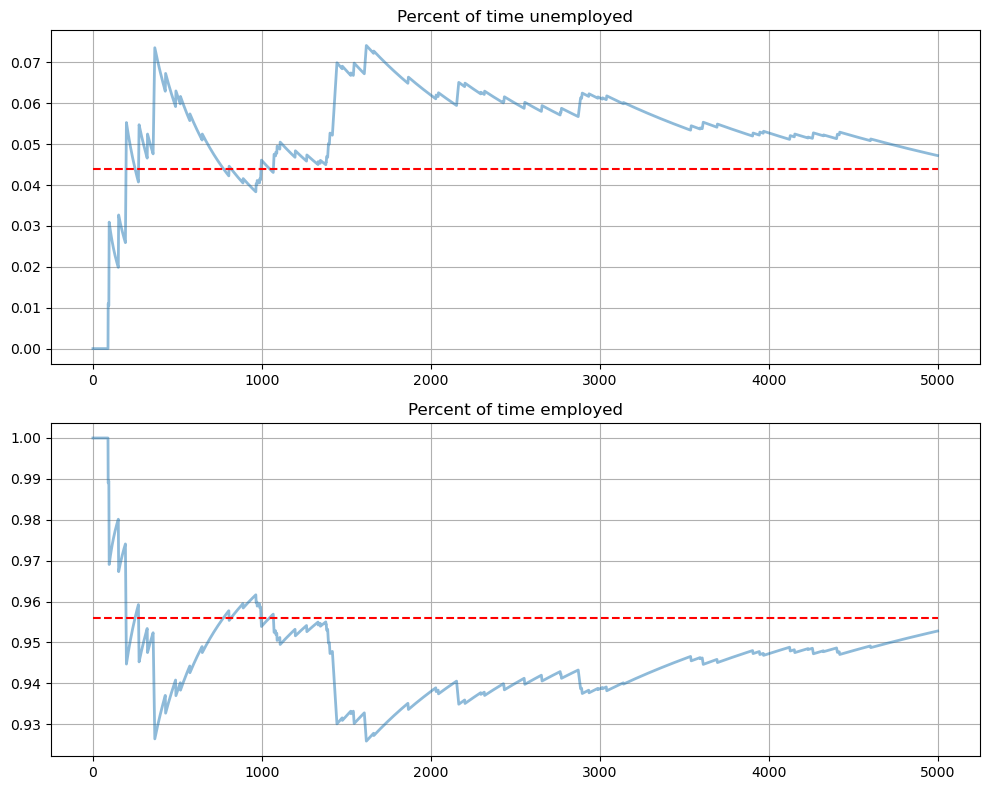

In [10]:
lm = LakeModel(d=0, b=0)
T = 5000  # Simulation length

α, λ = lm.α, lm.λ

P = [[1 - λ,        λ],
    [    α,    1 - α]]

mc = MarkovChain(P)

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
s_path = mc.simulate(T, init=1)
s_bar_e = s_path.cumsum() / range(1, T+1)
s_bar_u = 1 - s_bar_e

to_plot = [s_bar_u, s_bar_e]
titles = ['Percent of time unemployed', 'Percent of time employed']

for i, plot in enumerate(to_plot):
    axes[i].plot(plot, lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(titles[i])
    axes[i].grid()

plt.tight_layout()
plt.show()

The stationary probabilities are given by the dashed red line.

In this case it takes much of the sample for these two objects to converge.

This is largely due to the high persistence in the Markov chain.

## Endogenous Job Finding Rate

We now make the hiring rate endogenous.

The transition rate from unemployment to employment will be determined by the McCall search model {cite}`McCall1970`.

All details relevant to the following discussion can be found in {doc}`our treatment <mccall_model>` of that model.

### Reservation Wage

The most important thing to remember about the model is that optimal decisions
are characterized by a reservation wage $\bar w$

* If the wage offer $w$ in hand is greater than or equal to $\bar w$, then the worker accepts.
* Otherwise, the worker rejects.

As we saw in {doc}`our discussion of the model <mccall_model>`, the reservation wage depends on the wage offer distribution and the parameters

* $\alpha$, the separation rate
* $\beta$, the discount factor
* $\gamma$, the offer arrival rate
* $c$, unemployment compensation

### Linking the McCall Search Model to the Lake Model

Suppose that  all workers inside a lake model behave according to the McCall search model.

The exogenous probability of leaving employment remains $\alpha$.

But their optimal decision rules determine the probability $\lambda$ of leaving unemployment.

This is now

```{math}
:label: lake_lamda

\lambda
= \gamma \mathbb P \{ w_t \geq \bar w\}
= \gamma \sum_{w' \geq \bar w} p(w')
```

### Fiscal Policy

We can use the McCall search version of the Lake Model  to find an optimal level of unemployment insurance.

We assume that  the government sets unemployment compensation $c$.

The government imposes a lump-sum tax $\tau$ sufficient to finance total unemployment payments.

To attain a balanced budget at a steady state, taxes, the steady state unemployment rate $u$, and the unemployment compensation rate must satisfy

$$
\tau = u c
$$

The lump-sum tax applies to everyone, including unemployed workers.

Thus, the post-tax income of an employed worker with wage $w$ is $w - \tau$.

The post-tax income of an unemployed worker is $c - \tau$.

For each specification $(c, \tau)$ of government policy, we can solve for the worker's optimal reservation wage.

This determines $\lambda$ via {eq}`lake_lamda` evaluated at post tax wages, which in turn determines a steady state unemployment rate $u(c, \tau)$.

For a given level of unemployment benefit $c$, we can solve for a tax that balances the budget in the steady state

$$
\tau = u(c, \tau) c
$$

To evaluate alternative government tax-unemployment compensation pairs, we require a welfare criterion.

We use a steady state welfare criterion

$$
W := e \,  {\mathbb E} [V \, | \,  \text{employed}] + u \,  U
$$

where the notation $V$ and $U$ is as defined in the {doc}`McCall search model lecture <mccall_model>`.

The wage offer distribution will be a discretized version of the lognormal distribution $LN(\log(20),1)$, as shown in the next figure

```{figure} /_static/lecture_specific/lake_model/lake_distribution_wages.png

```

We take a period to be a month.

We set $b$ and $d$ to match monthly [birth](https://www.cdc.gov/nchs/fastats/births.htm) and [death rates](https://www.cdc.gov/nchs/fastats/deaths.htm), respectively, in the U.S. population

* $b = 0.0124$
* $d = 0.00822$

Following {cite}`davis2006flow`, we set $\alpha$, the hazard rate of leaving employment, to

* $\alpha = 0.013$

### Fiscal Policy Code

We will make use of techniques from the {doc}`McCall model lecture <mccall_model>`

The first piece of code implements value function iteration

In [11]:
# A default utility function

@jit
def u(c, σ):
    if c > 0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return -10e6


class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self,
                α=0.2,       # Job separation rate
                β=0.98,      # Discount rate
                γ=0.7,       # Job offer rate
                c=6.0,       # Unemployment compensation
                σ=2.0,       # Utility parameter
                w_vec=None,  # Possible wage values
                p_vec=None): # Probabilities over w_vec

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ

        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vec is None:
            n = 60  # Number of possible outcomes for wage
            # Wages between 10 and 20
            self.w_vec = np.linspace(10, 20, n)
            a, b = 600, 400  # Shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.p_vec = dist.pdf()
        else:
            self.w_vec = w_vec
            self.p_vec = p_vec

@jit
def _update_bellman(α, β, γ, c, σ, w_vec, p_vec, V, V_new, U):
    """
    A jitted function to update the Bellman equations.  Note that V_new is
    modified in place (i.e, modified by this function).  The new value of U
    is returned.

    """
    for w_idx, w in enumerate(w_vec):
        # w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)

    U_new = u(c, σ) + β * (1 - γ) * U + \
                    β * γ * np.sum(np.maximum(U, V) * p_vec)

    return U_new


def solve_mccall_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    Parameters
    ----------
    mcm : an instance of McCallModel
    tol : float
        error tolerance
    max_iter : int
        the maximum number of iterations
    """

    V = np.ones(len(mcm.w_vec))  # Initial guess of V
    V_new = np.empty_like(V)     # To store updates to V
    U = 1                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        U_new = _update_bellman(mcm.α, mcm.β, mcm.γ,
                mcm.c, mcm.σ, mcm.w_vec, mcm.p_vec, V, V_new, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1

    return V, U

The second piece of code is used to complete the reservation wage:

In [12]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U.

    If V(w) > U for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vec.

    If v(w) < U for all w, then w_bar is set to np.inf.

    Parameters
    ----------
    mcm : an instance of McCallModel
    return_values : bool (optional, default=False)
        Return the value functions as well

    Returns
    -------
    w_bar : scalar
        The reservation wage

    """

    V, U = solve_mccall_model(mcm)
    w_idx = np.searchsorted(V - U, 0)

    if w_idx == len(V):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]

    if return_values == False:
        return w_bar
    else:
        return w_bar, V, U

Now let's compute and plot welfare, employment, unemployment, and tax revenue as a
function of the unemployment compensation rate

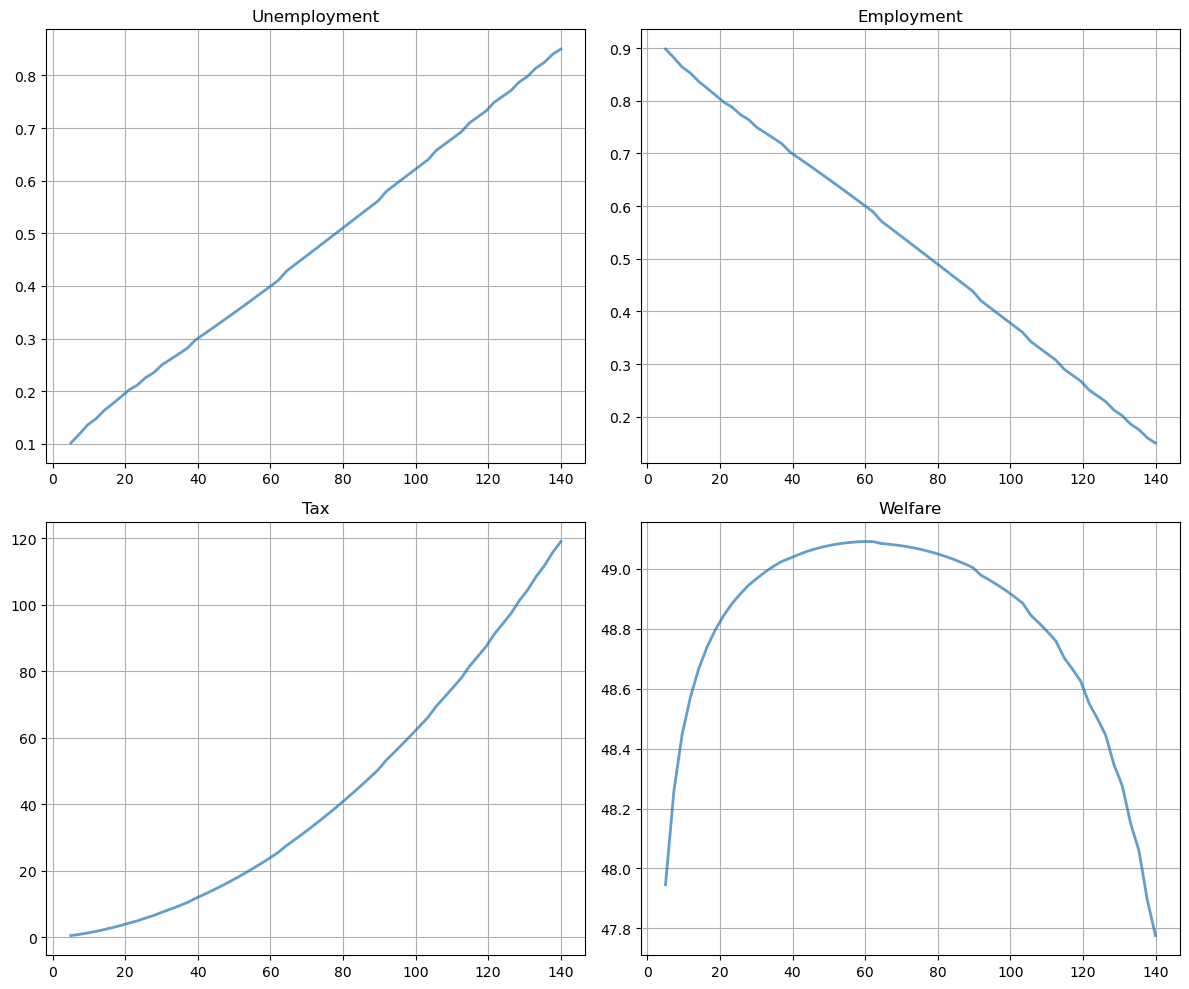

In [13]:
# Some global variables that will stay constant
α = 0.013
α_q = (1-(1-α)**3)   # Quarterly (α is monthly)
b = 0.0124
d = 0.00822
β = 0.98
γ = 1.0
σ = 2.0

# The default wage distribution --- a discretized lognormal
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(1e-8, max_wage, wage_grid_size + 1)
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:] - cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1]) / 2


def compute_optimal_quantities(c, τ):
    """
    Compute the reservation wage, job finding rate and value functions
    of the workers given c and τ.

    """

    mcm = McCallModel(α=α_q,
                    β=β,
                    γ=γ,
                    c=c-τ,          # Post tax compensation
                    σ=σ,
                    w_vec=w_vec-τ,  # Post tax wages
                    p_vec=p_vec)

    w_bar, V, U = compute_reservation_wage(mcm, return_values=True)
    λ = γ * np.sum(p_vec[w_vec - τ > w_bar])
    return w_bar, λ, V, U

def compute_steady_state_quantities(c, τ):
    """
    Compute the steady state unemployment rate given c and τ using optimal
    quantities from the McCall model and computing corresponding steady
    state quantities

    """
    w_bar, λ, V, U = compute_optimal_quantities(c, τ)

    # Compute steady state employment and unemployment rates
    lm = LakeModel(α=α_q, λ=λ, b=b, d=d)
    x = lm.rate_steady_state()
    u, e = x

    # Compute steady state welfare
    w = np.sum(V * p_vec * (w_vec - τ > w_bar)) / np.sum(p_vec * (w_vec -
            τ > w_bar))
    welfare = e * w + u * U

    return e, u, welfare


def find_balanced_budget_tax(c):
    """
    Find the tax level that will induce a balanced budget.

    """
    def steady_state_budget(t):
        e, u, w = compute_steady_state_quantities(c, t)
        return t - u * c

    τ = brentq(steady_state_budget, 0.0, 0.9 * c)
    return τ


# Levels of unemployment insurance we wish to study
c_vec = np.linspace(5, 140, 60)

tax_vec = []
unempl_vec = []
empl_vec = []
welfare_vec = []

for c in c_vec:
    t = find_balanced_budget_tax(c)
    e_rate, u_rate, welfare = compute_steady_state_quantities(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(e_rate)
    welfare_vec.append(welfare)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plots = [unempl_vec, empl_vec, tax_vec, welfare_vec]
titles = ['Unemployment', 'Employment', 'Tax', 'Welfare']

for ax, plot, title in zip(axes.flatten(), plots, titles):
    ax.plot(c_vec, plot, lw=2, alpha=0.7)
    ax.set_title(title)
    ax.grid()

plt.tight_layout()
plt.show()

Welfare first increases and then decreases as unemployment benefits rise.

The level that maximizes steady state welfare is approximately 62.

## Exercises

```{exercise}
:label: lm_ex1

In the Lake Model, there is derived data such as $A$ which depends on primitives like $\alpha$
and $\lambda$.

So, when a user alters these primitives, we need the derived data to update automatically.

(For example, if a user changes the value of $b$ for a given instance of the class, we would like $g = b - d$ to update automatically)

In the code above, we took care of this issue by creating new instances every time we wanted to change parameters.

That way the derived data is always matched to current parameter values.

However, we can use descriptors instead, so that derived data is updated whenever parameters are changed.

This is safer and means we don't need to create a fresh instance for every new parameterization.

(On the other hand, the code becomes denser, which is why we don't always use the descriptor approach in our lectures.)

In this exercise, your task is to arrange the `LakeModel` class by using descriptors and decorators such as `@property`.

(If you need to refresh your understanding of how these work, consult [this lecture](https://python-programming.quantecon.org/python_advanced_features.html).)
```

```{solution-start} lm_ex1
:class: dropdown
```

Here is one solution

In [14]:
class LakeModelModified:
    """
    Solves the lake model and computes dynamics of unemployment stocks and
    rates.

    Parameters:
    ------------
    λ : scalar
        The job finding rate for currently unemployed workers
    α : scalar
        The dismissal rate for currently employed workers
    b : scalar
        Entry rate into the labor force
    d : scalar
        Exit rate from the labor force

    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self._λ, self._α, self._b, self._d = λ, α, b, d
        self.compute_derived_values()

    def compute_derived_values(self):
        # Unpack names to simplify expression
        λ, α, b, d = self._λ, self._α, self._b, self._d

        self._g = b - d
        self._A = np.array([[(1-d) * (1-λ) + b,      (1 - d) * α + b],
                            [        (1-d) * λ,   (1 - d) * (1 - α)]])

        self._A_hat = self._A / (1 + self._g)

    @property
    def g(self):
        return self._g

    @property
    def A(self):
        return self._A

    @property
    def A_hat(self):
        return self._A_hat

    @property
    def λ(self):
        return self._λ

    @λ.setter
    def λ(self, new_value):
        self._λ = new_value
        self.compute_derived_values()

    @property
    def α(self):
        return self._α

    @α.setter
    def α(self, new_value):
        self._α = new_value
        self.compute_derived_values()

    @property
    def b(self):
        return self._b

    @b.setter
    def b(self, new_value):
        self._b = new_value
        self.compute_derived_values()

    @property
    def d(self):
        return self._d

    @d.setter
    def d(self, new_value):
        self._d = new_value
        self.compute_derived_values()


    def rate_steady_state(self, tol=1e-6):
        """
        Finds the steady state of the system :math:`x_{t+1} = \hat A x_{t}`

        Returns
        --------
        xbar : steady state vector of employment and unemployment rates
        """
        x = np.full(2, 0.5)
        error = tol + 1
        while error > tol:
            new_x = self.A_hat @ x
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x

    def simulate_stock_path(self, X0, T):
        """
        Simulates the sequence of Employment and Unemployment stocks

        Parameters
        ------------
        X0 : array
            Contains initial values (E0, U0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        X : iterator
            Contains sequence of employment and unemployment stocks
        """

        X = np.atleast_1d(X0)  # Recast as array just in case
        for t in range(T):
            yield X
            X = self.A @ X

    def simulate_rate_path(self, x0, T):
        """
        Simulates the sequence of employment and unemployment rates

        Parameters
        ------------
        x0 : array
            Contains initial values (e0,u0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        x : iterator
            Contains sequence of employment and unemployment rates

        """
        x = np.atleast_1d(x0)  # Recast as array just in case
        for t in range(T):
            yield x
            x = self.A_hat @ x

```{solution-end}
```

```{exercise-start}
:label: lm_ex2
```

Consider an economy with an initial stock  of workers $N_0 = 100$ at the
steady state level of employment in the baseline parameterization

* $\alpha = 0.013$
* $\lambda = 0.283$
* $b = 0.0124$
* $d = 0.00822$

(The values for $\alpha$ and $\lambda$ follow {cite}`davis2006flow`)

Suppose that in response to new legislation the hiring rate reduces to $\lambda = 0.2$.

Plot the transition dynamics of the unemployment and employment stocks for 50 periods.

Plot the transition dynamics for the rates.

How long does the economy take to converge to its new steady state?

What is the new steady state level of employment?

```{note}
It may be easier to use the class created in exercise 1 to help with changing variables.
```

```{exercise-end}
```


```{solution-start} lm_ex2
:class: dropdown
```

We begin by constructing the class containing the default parameters and assigning the
steady state values to `x0`

In [15]:
lm = LakeModelModified()
x0 = lm.rate_steady_state()
print(f"Initial Steady State: {x0}")

Initial Steady State: [0.08266806 0.91733194]


Initialize the simulation values

In [16]:
N0 = 100
T = 50

New legislation changes $\lambda$ to $0.2$

In [17]:
lm.λ = 0.2

xbar = lm.rate_steady_state()  # new steady state
X_path = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T)))
x_path = np.vstack(tuple(lm.simulate_rate_path(x0, T)))
print(f"New Steady State: {xbar}")

New Steady State: [0.11309573 0.88690427]


Now plot stocks

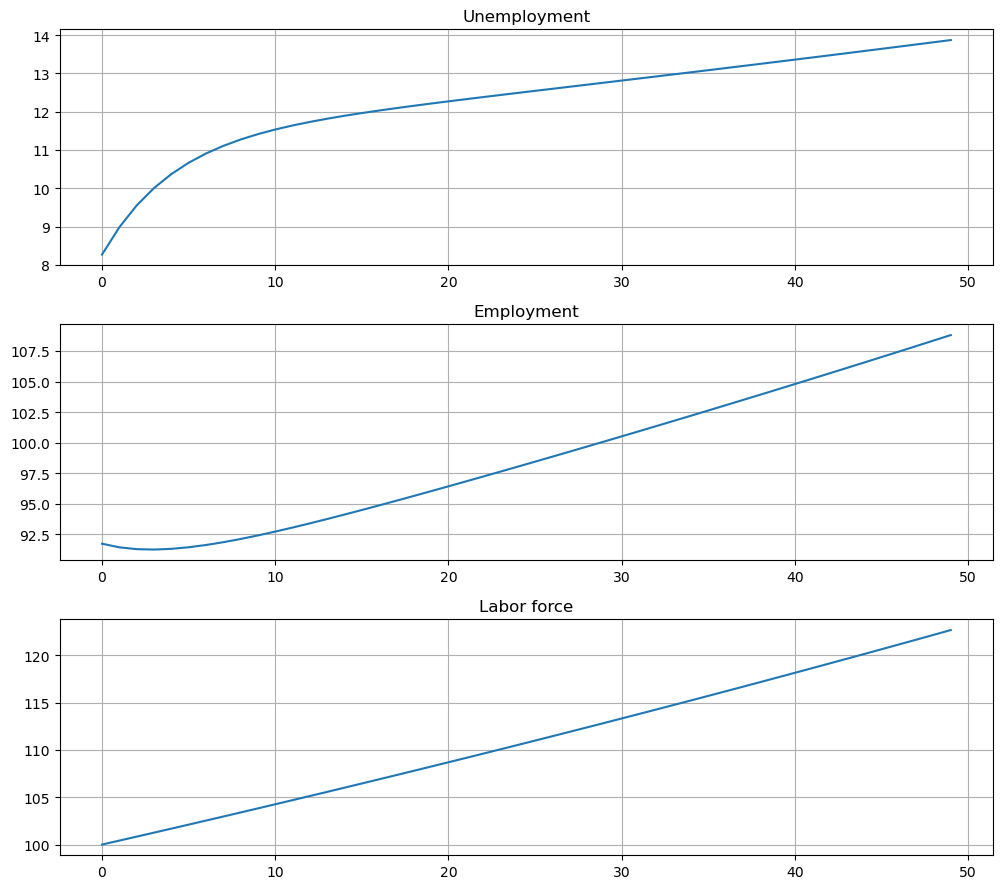

In [18]:
fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1])
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1))
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

And how the rates evolve

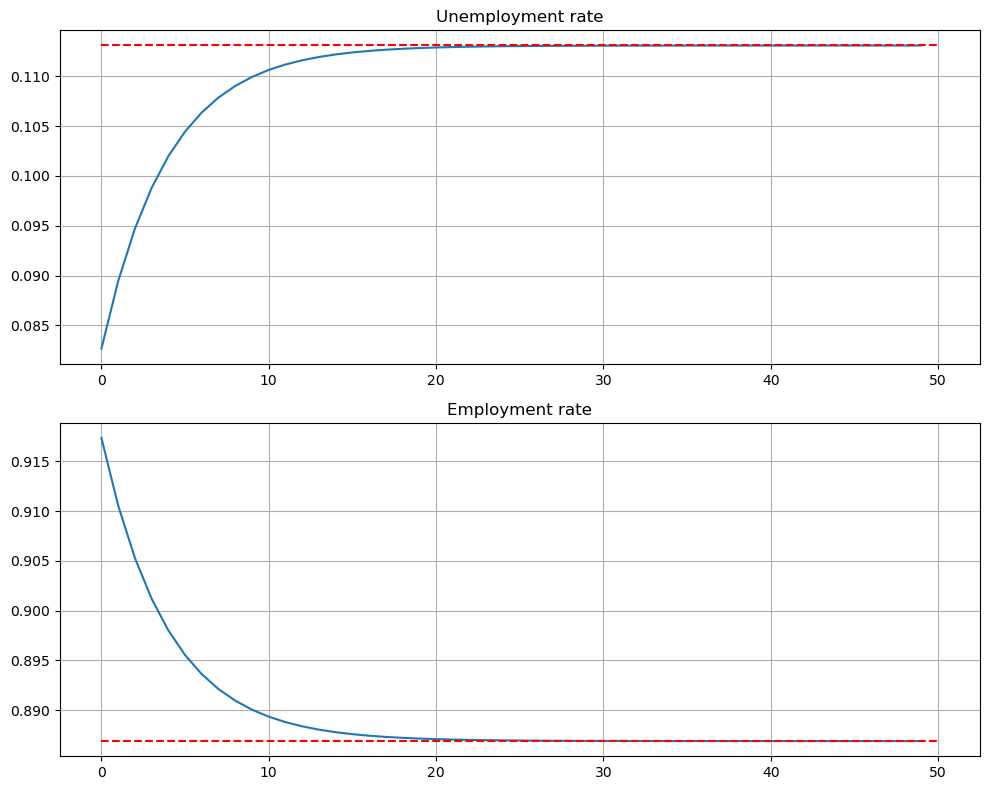

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

We see that it takes 20 periods for the economy to converge to its new
steady state levels.

```{solution-end}
```


```{exercise}
:label: lm_ex3

Consider an economy with an initial stock  of workers $N_0 = 100$ at the
steady state level of employment in the baseline parameterization.

Suppose that for 20 periods the birth rate was temporarily high ($b = 0.025$) and then returned to its original level.

Plot the transition dynamics of the unemployment and employment stocks for 50 periods.

Plot the transition dynamics for the rates.

How long does the economy take to return to its original steady state?
```

```{solution-start} lm_ex3
:class: dropdown
```

This next exercise has the economy experiencing a boom in entrances to
the labor market and then later returning to the original levels.

For 20 periods the economy has a new entry rate into the labor market.

Let's start off at the baseline parameterization and record the steady
state

In [20]:
lm = LakeModelModified()
x0 = lm.rate_steady_state()

Here are the other parameters:

In [21]:
b_hat = 0.025
T_hat = 20

Let's increase $b$ to the new value and simulate for 20 periods

In [22]:
lm.b = b_hat
# Simulate stocks
X_path1 = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T_hat)))
# Simulate rates
x_path1 = np.vstack(tuple(lm.simulate_rate_path(x0, T_hat)))

Now we reset $b$ to the original value and then, using the state
after 20 periods for the new initial conditions, we simulate for the
additional 30 periods

In [23]:
lm.b = 0.0124
# Simulate stocks
X_path2 = np.vstack(tuple(lm.simulate_stock_path(X_path1[-1, :2], T-T_hat+1)))
# Simulate rates
x_path2 = np.vstack(tuple(lm.simulate_rate_path(x_path1[-1, :2], T-T_hat+1)))

Finally, we combine these two paths and plot

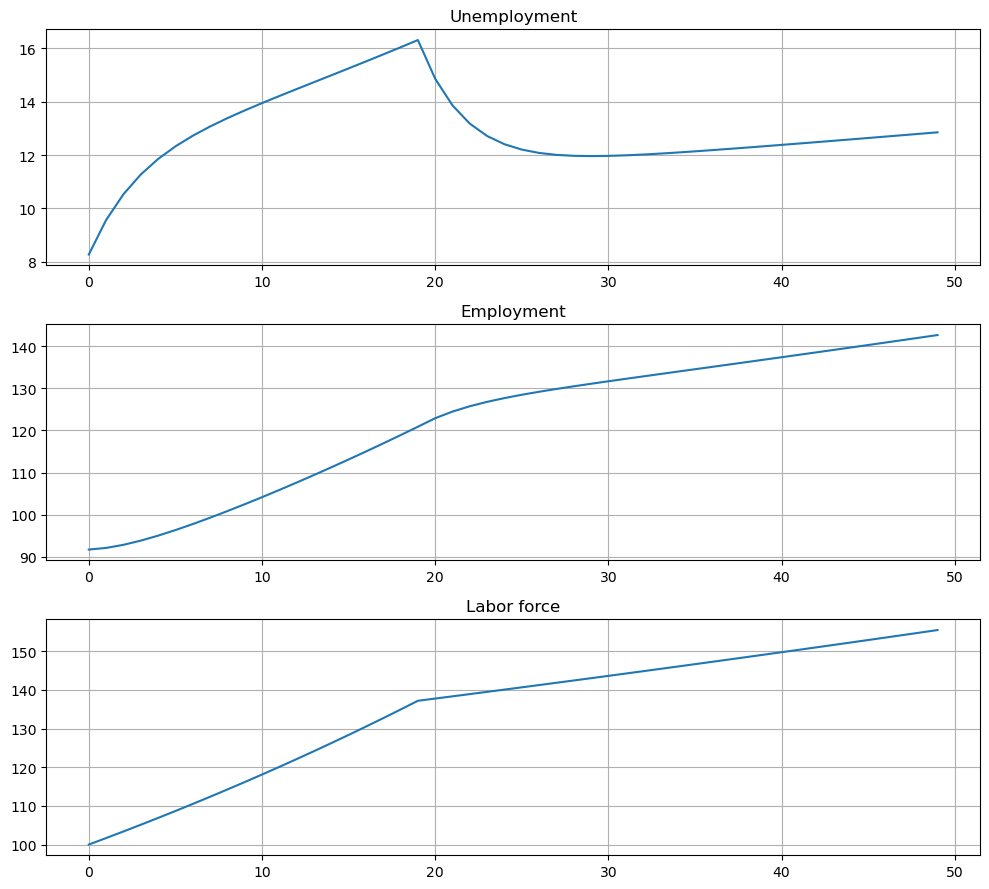

In [24]:
# note [1:] to avoid doubling period 20
x_path = np.vstack([x_path1, x_path2[1:]])
X_path = np.vstack([X_path1, X_path2[1:]])

fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1])
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1))
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

And the rates

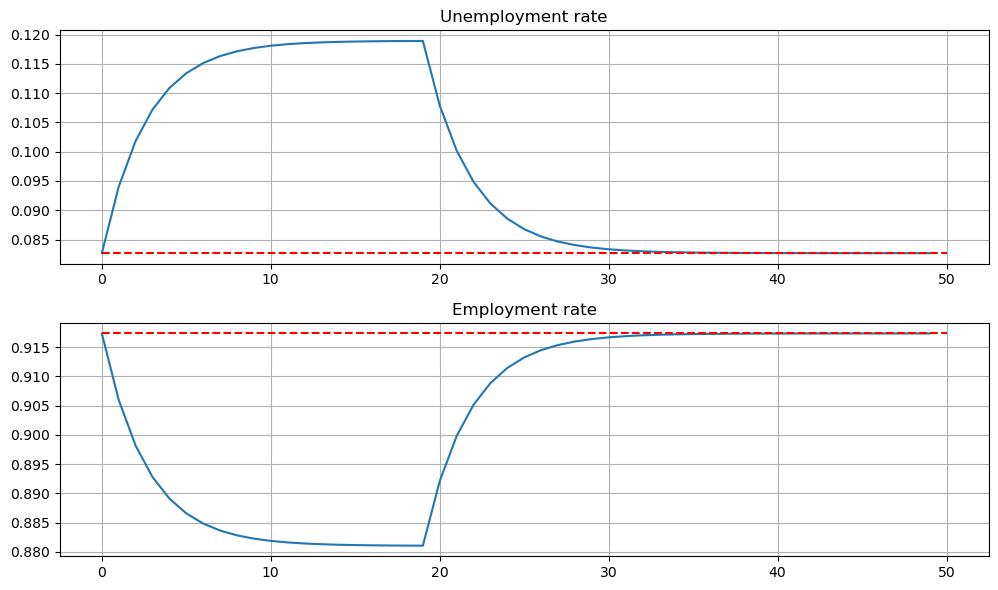

In [25]:
fig, axes = plt.subplots(2, 1, figsize=[10, 6])

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(x0[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

```{solution-end}
```